In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import sys; sys.path.append('../src')

In [2]:
from models.layers import NestedDropout
from models.cmpnts import MLP, SNMLP
from models.layers import SNLinearCombo
from torch.linalg import svd

# 2D
## 1D Manifold

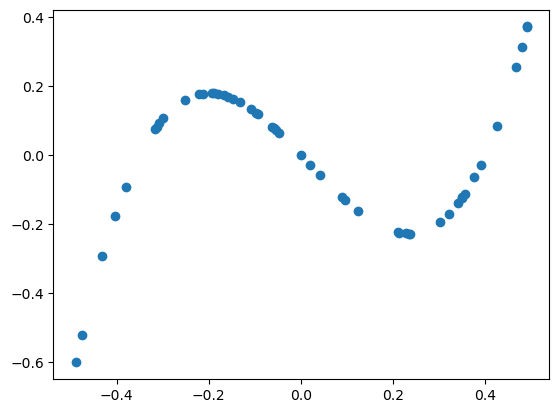

In [114]:
encoder = MLP(2, 2, [32]*4)
decoder = SNMLP(2, 2, [32]*4)
encoder.train()
decoder.train()

X, _ = torch.sort(torch.rand(50))
X = X - 0.5
# Y = X + 5 * X ** 3 
Y = 10 * (X-0.4) * X * (X+0.35)

plt.scatter(X.numpy(), Y.numpy())
plt.show()

In [116]:
data = torch.stack([X, Y], dim=-1)
opt = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-3)

for i in range(10000):
    opt.zero_grad()
    z = encoder(data)
    rec_loss = F.mse_loss(decoder(z), data) 
    lasso_loss = torch.exp(torch.log(z.std(0)).mean()) # torch.norm(z.std(0), p=1)
    # F.mse_loss(z.T.cov().tril(diagonal=-1), torch.zeros_like(z.T.cov()))
    loss = rec_loss #+ 0.01 * lasso_loss
    loss.backward()
    opt.step()

    if i % 100 == 0:
        print('Epoch {}: rec = {}, lasso = {}'.format(i, rec_loss, lasso_loss))

Epoch 0: rec = 7.259641421342167e-08, lasso = 2.4979805946350098
Epoch 100: rec = 2.657456263932545e-07, lasso = 2.484377384185791
Epoch 200: rec = 1.390609725149261e-07, lasso = 2.4834799766540527
Epoch 300: rec = 1.0930229166206118e-07, lasso = 2.483877420425415
Epoch 400: rec = 9.485366803119177e-08, lasso = 2.48425555229187
Epoch 500: rec = 8.60406643710121e-08, lasso = 2.4843132495880127
Epoch 600: rec = 8.008968421790996e-08, lasso = 2.4841349124908447
Epoch 700: rec = 8.431088360794092e-08, lasso = 2.4852635860443115
Epoch 800: rec = 7.252118194855939e-08, lasso = 2.4875309467315674
Epoch 900: rec = 9.409389178927086e-08, lasso = 2.489499568939209
Epoch 1000: rec = 7.467740203992435e-08, lasso = 2.4923155307769775
Epoch 1100: rec = 1.7370720684084517e-07, lasso = 2.4965319633483887
Epoch 1200: rec = 7.294645598676652e-08, lasso = 2.4951281547546387
Epoch 1300: rec = 6.43886082229983e-08, lasso = 2.499502420425415
Epoch 1400: rec = 3.881900454416609e-07, lasso = 2.504991531372070

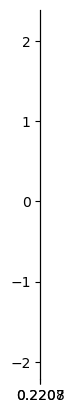

In [109]:
encoder.eval()
decoder.eval()

z = encoder(data)
plt.scatter(z[:,0].detach().numpy(), z[:,1].detach().numpy())
plt.gca().set_aspect('equal')
plt.show()

In [110]:
z.max(0)[0] - z.min(0)[0]

tensor([1.7802e-04, 4.1881e+00], grad_fn=<SubBackward0>)

In [111]:
z.T.cov()

tensor([[ 2.5861e-09, -2.9243e-05],
        [-2.9243e-05,  1.1691e+00]], grad_fn=<SqueezeBackward0>)

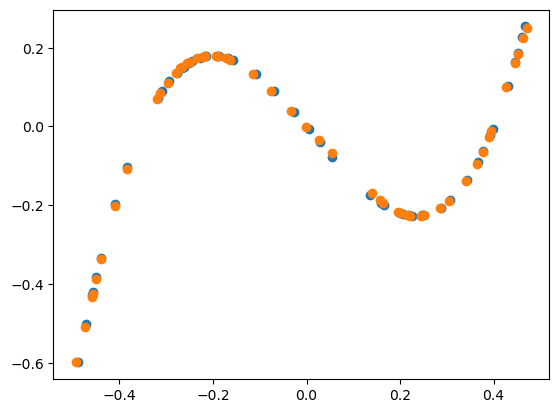

In [112]:
rec = decoder(z).detach().numpy()
plt.scatter(X.numpy(), Y.numpy())
plt.scatter(rec[:, 0], rec[:, 1])

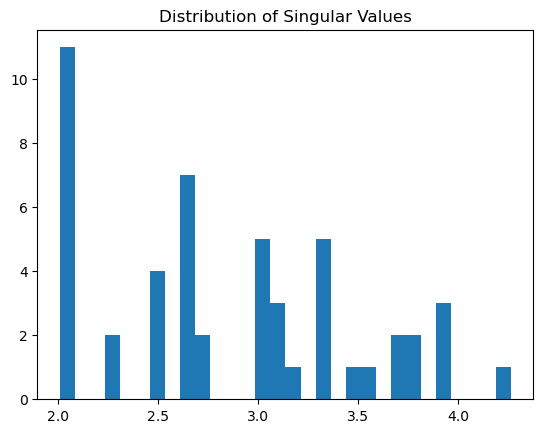

In [113]:
def f(x):
    return encoder(x).sum(0)

jcb = torch.autograd.functional.jacobian(f, data).transpose(1,0)
eig_list = torch.stack([svd(j[[1]])[1] for j in jcb])
plt.hist(eig_list.numpy(), bins=30)
plt.title('Distribution of Singular Values')
plt.show()

## 2D Manifold

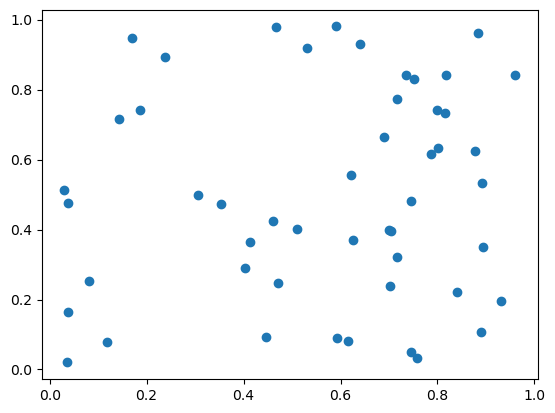

In [36]:
encoder = MLP(2, 2, [32, 32, 32]) # MLP(2, 2, [32, 32, 32]) 
decoder = SNMLP(2, 2, [32, 32, 32])
encoder.train()
decoder.train()

data = torch.rand(50, 2)
plt.scatter(data[:,0].numpy(), data[:,1].numpy())
plt.show()

In [37]:
opt = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-3)

for i in range(10000):
    opt.zero_grad()
    z = encoder(data)
    rec_loss = F.mse_loss(decoder(z), data) 
    lasso_loss = torch.exp(torch.log(z.std(0)+1).mean()) # torch.norm(z.std(0), p=1)
    # F.mse_loss(z.T.cov().tril(diagonal=-1), torch.zeros_like(z.T.cov()))
    loss = rec_loss + 0.001 * lasso_loss
    loss.backward()
    opt.step()

    if i % 100 == 0:
        print('Epoch {}: rec = {}, lasso = {}'.format(i, rec_loss, lasso_loss))

Epoch 0: rec = 0.581045389175415, lasso = 1.0121126174926758
Epoch 100: rec = 0.04236476868391037, lasso = 2.015660285949707
Epoch 200: rec = 0.032273951917886734, lasso = 2.38560152053833
Epoch 300: rec = 0.00031826947815716267, lasso = 2.723750352859497
Epoch 400: rec = 8.970166527433321e-05, lasso = 2.461263418197632
Epoch 500: rec = 4.30733198300004e-05, lasso = 2.21065092086792
Epoch 600: rec = 2.4552393369958736e-05, lasso = 2.0256519317626953
Epoch 700: rec = 1.7729877072270028e-05, lasso = 1.9233293533325195
Epoch 800: rec = 3.3373777114320546e-05, lasso = 1.8368324041366577
Epoch 900: rec = 8.9932300397777e-06, lasso = 1.7416502237319946
Epoch 1000: rec = 2.5092427677009255e-05, lasso = 1.6930476427078247
Epoch 1100: rec = 1.099014207284199e-05, lasso = 1.6382309198379517
Epoch 1200: rec = 7.292790542123839e-06, lasso = 1.5989587306976318
Epoch 1300: rec = 8.66576283442555e-06, lasso = 1.5436805486679077
Epoch 1400: rec = 7.565532087028259e-06, lasso = 1.5224623680114746
Epoch

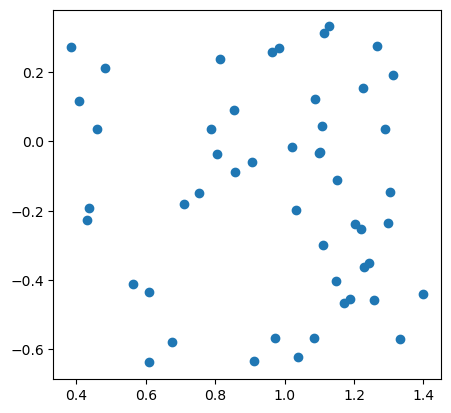

In [38]:
encoder.eval()
decoder.eval()

z = encoder(data)
plt.scatter(z[:,0].detach().numpy(), z[:,1].detach().numpy())
plt.gca().set_aspect('equal')
plt.show()

In [39]:
z.max(0)[0] - z.min(0)[0]

tensor([1.0154, 0.9683], grad_fn=<SubBackward0>)

In [40]:
z.T.cov()

tensor([[ 0.0824, -0.0083],
        [-0.0083,  0.0853]], grad_fn=<SqueezeBackward0>)

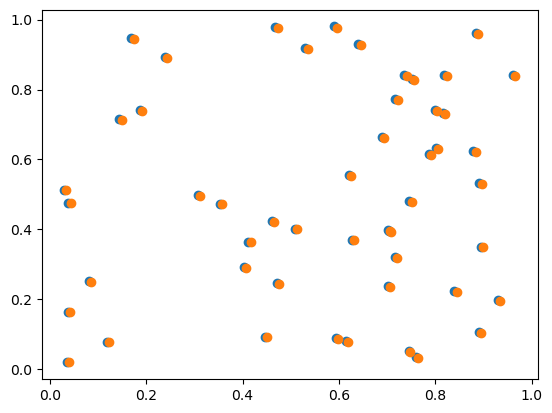

In [41]:
rec = decoder(z).detach().numpy()
plt.scatter(data[:,0].numpy(), data[:,1].numpy())
plt.scatter(rec[:, 0], rec[:, 1])

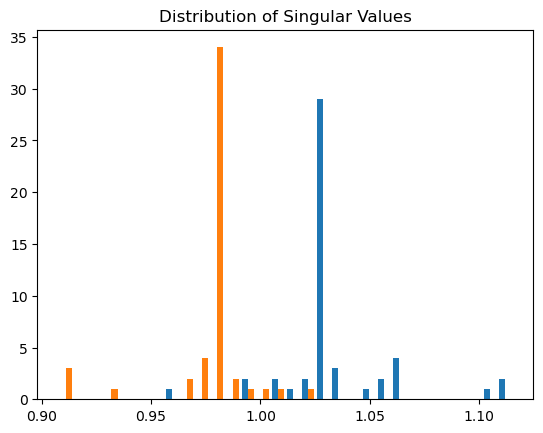

In [42]:
def f(x):
    return encoder(x).sum(0)

jcb = torch.autograd.functional.jacobian(f, data).transpose(1,0)
eig_list = torch.stack([svd(j[[0, 1]])[1] for j in jcb])
plt.hist(eig_list.numpy(), bins=30)
plt.title('Distribution of Singular Values')
plt.show()

## Swiss Roll

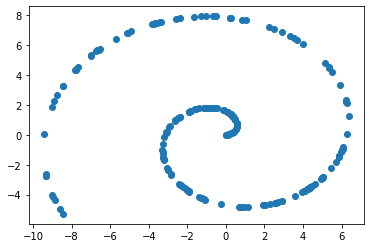

In [18]:
encoder =  MLP(2, 2, [32, 32, 32, 32]) 
decoder = SNMLP(2, 2, [32, 32, 32, 32])
encoder.train()
decoder.train()

X, _ = torch.sort(torch.rand(200)*10)
data = torch.stack([X * torch.cos(X), X * torch.sin(X)], dim=-1)
plt.scatter(data[:, 0], data[:, 1])
plt.show()

In [55]:
opt = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-3)

for i in range(50000):
    opt.zero_grad()
    z = encoder(data)
    rec_loss = F.mse_loss(decoder(z), data) 
    lasso_loss = torch.exp(torch.log(z.std(0)).mean()) # torch.norm(z.std(0), p=1)
    # F.mse_loss(z.T.cov().tril(diagonal=-1), torch.zeros_like(z.T.cov()))
    loss = rec_loss + 10 * lasso_loss
    loss.backward()
    opt.step()

    if i % 100 == 0:
        print('Epoch {}: rec = {}, lasso = {}'.format(i, rec_loss, lasso_loss))

Epoch 0: rec = 16.89276695251465, lasso = 0.02861848659813404
Epoch 100: rec = 16.380664825439453, lasso = 0.0017511197365820408
Epoch 200: rec = 16.380678176879883, lasso = 0.00036878586979582906
Epoch 300: rec = 16.380718231201172, lasso = 0.00180992076639086
Epoch 400: rec = 16.380706787109375, lasso = 0.000705557584296912
Epoch 500: rec = 16.380687713623047, lasso = 0.0007417819579131901
Epoch 600: rec = 16.380687713623047, lasso = 0.00021276094776112586
Epoch 700: rec = 16.380678176879883, lasso = 0.000530098332092166
Epoch 800: rec = 16.380687713623047, lasso = 0.000248874188400805
Epoch 900: rec = 16.380666732788086, lasso = 0.0003455124387983233
Epoch 1000: rec = 16.380687713623047, lasso = 0.0006027947529219091
Epoch 1100: rec = 16.38068199157715, lasso = 0.00016561071970500052
Epoch 1200: rec = 16.380691528320312, lasso = 0.00018427013128530234
Epoch 1300: rec = 16.38066864013672, lasso = 0.00024079975264612585
Epoch 1400: rec = 16.380661010742188, lasso = 0.00047543045366182

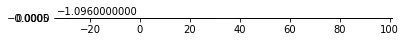

In [56]:
encoder.eval()
decoder.eval()

z = encoder(data)
plt.scatter(z[:,0].detach().numpy(), z[:,1].detach().numpy())
plt.gca().set_aspect('equal')
plt.show()

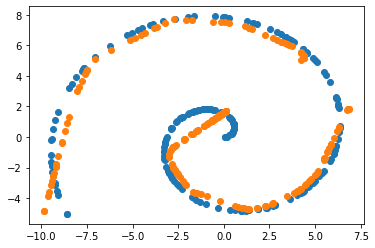

In [57]:
rec = decoder(z).detach().numpy()
plt.scatter(data[:,0].numpy(), data[:,1].numpy())
plt.scatter(rec[:, 0], rec[:, 1])

# 3D
## 1D Manifold

C:\Users\geniu\AppData\Local\Temp\ipykernel_170496\4187592486.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


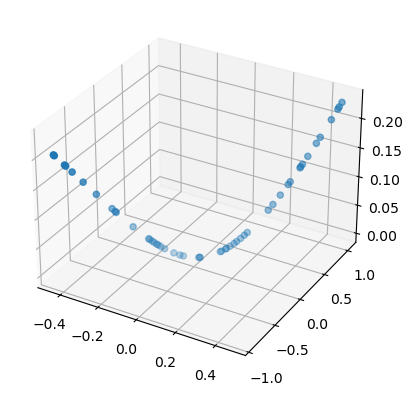

In [43]:
encoder = MLP(3, 3, [32, 32, 32, 32])
decoder = SNMLP(3, 3, [32, 32, 32, 32])
encoder.train()
decoder.train()

X, _ = torch.sort(torch.rand(50))
X = X - 0.5
Y = X + 5 * X ** 3
Z = X ** 2
data = torch.stack([X, Y, Z], dim=-1)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X.numpy(), Y.numpy(), Z.numpy())
fig.show()

In [44]:
opt = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-3)

for i in range(10000):
    opt.zero_grad()
    z = encoder(data)
    rec_loss = F.mse_loss(decoder(z), data) 
    lasso_loss = torch.exp(torch.log(z.std(0)+1e-3).mean()) # torch.norm(z.std(0), p=1)
    # F.mse_loss(z.T.cov().tril(diagonal=-1), torch.zeros_like(z.T.cov())) 
    loss = rec_loss + 0.01 * lasso_loss
    loss.backward()
    opt.step()

    if i % 100 == 0:
        print('Epoch {}: rec = {}, lasso = {}'.format(i, rec_loss, lasso_loss))

Epoch 0: rec = 0.1494358777999878, lasso = 0.004826890304684639
Epoch 100: rec = 0.007644610479474068, lasso = 0.11113985627889633
Epoch 200: rec = 0.00019576707563828677, lasso = 0.0730993002653122
Epoch 300: rec = 7.804802589816973e-05, lasso = 0.06331777572631836
Epoch 400: rec = 3.831214053207077e-05, lasso = 0.049464523792266846
Epoch 500: rec = 2.1859457774553448e-05, lasso = 0.05323846638202667
Epoch 600: rec = 1.6000169125618413e-05, lasso = 0.02435612864792347
Epoch 700: rec = 1.0774545444292016e-05, lasso = 0.023752477020025253
Epoch 800: rec = 1.040078313963022e-05, lasso = 0.0512843057513237
Epoch 900: rec = 7.294016540981829e-06, lasso = 0.05540395528078079
Epoch 1000: rec = 4.65578068542527e-06, lasso = 0.03344637528061867
Epoch 1100: rec = 3.495933469821466e-06, lasso = 0.015584171749651432
Epoch 1200: rec = 2.791957513181842e-06, lasso = 0.02058442309498787
Epoch 1300: rec = 1.8756089730231906e-06, lasso = 0.018462438136339188
Epoch 1400: rec = 3.599590854719281e-06, la

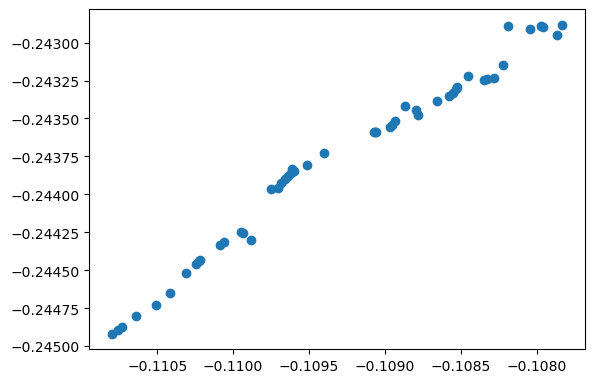

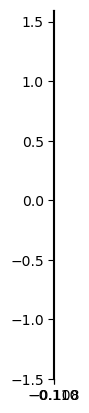

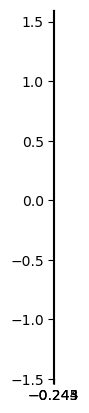

In [45]:
encoder.eval()
decoder.eval()

z = encoder(data)

plt.scatter(z[:,0].detach().numpy(), z[:,1].detach().numpy())
plt.gca().set_aspect('equal')
plt.show()

plt.scatter(z[:,0].detach().numpy(), z[:,2].detach().numpy())
plt.gca().set_aspect('equal')
plt.show()

plt.scatter(z[:,1].detach().numpy(), z[:,2].detach().numpy())
plt.gca().set_aspect('equal')
plt.show()

In [46]:
z.max(0)[0] - z.min(0)[0]

tensor([2.9707e-03, 2.0371e-03, 2.8201e+00], grad_fn=<SubBackward0>)

In [47]:
z.T.cov()

tensor([[7.6114e-07, 5.1632e-07, 6.3893e-04],
        [5.1632e-07, 3.5828e-07, 4.3767e-04],
        [6.3893e-04, 4.3767e-04, 5.5122e-01]], grad_fn=<SqueezeBackward0>)

C:\Users\geniu\AppData\Local\Temp\ipykernel_170496\3410414864.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


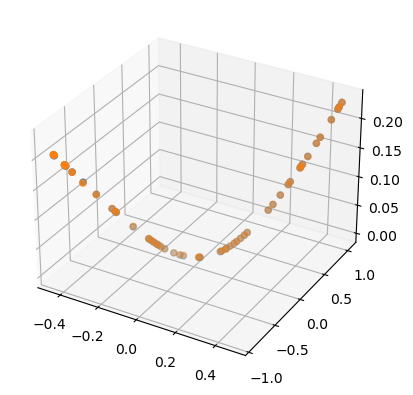

In [48]:
rec = decoder(z).detach().numpy()

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X.numpy(), Y.numpy(), Z.numpy())
ax.scatter(rec[:, 0], rec[:, 1], rec[:, 2])
fig.show()

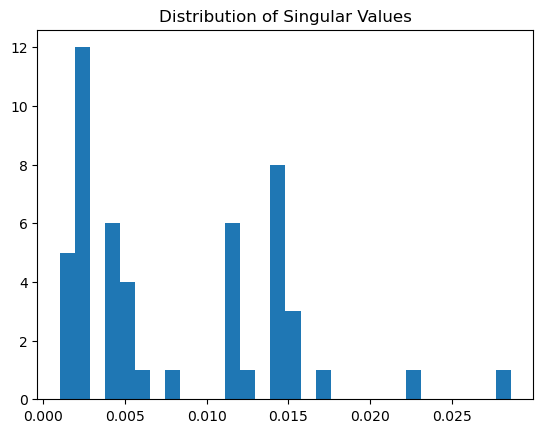

In [49]:
def f(x):
    return encoder(x).sum(0)

jcb = torch.autograd.functional.jacobian(f, data).transpose(1,0)
eig_list = torch.stack([svd(j[[1]])[1] for j in jcb])
plt.hist(eig_list.numpy(), bins=30)
plt.title('Distribution of Singular Values')
plt.show()

## 2D

C:\Users\geniu\AppData\Local\Temp\ipykernel_170496\1115527838.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


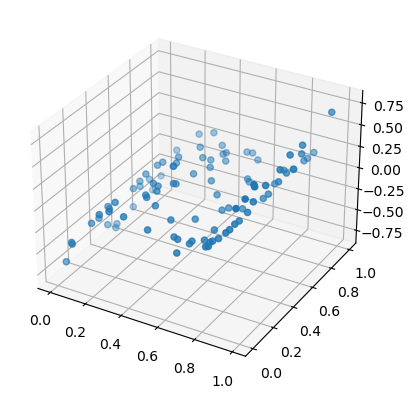

In [85]:
encoder = MLP(3, 3, [32, 32, 32, 32])
decoder = SNMLP(3, 3, [32, 32, 32, 32])
encoder.train()
decoder.train()

XY = torch.rand(100, 2)
X = XY[:, 0] - 0.5
Z = 10 * (X-0.3) * X * (X+0.3) 
data = torch.stack([XY[:,0], XY[:,1], Z], dim=-1)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(XY[:,0].numpy(), XY[:,1].numpy(), Z.numpy())
fig.show()

In [86]:
opt = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-4)

for i in range(10000):
    opt.zero_grad()
    z = encoder(data)
    rec_loss = F.mse_loss(decoder(z), data) 
    lasso_loss = torch.exp(torch.log(z.std(0) + 1).mean()) # torch.norm(z.std(0), p=1)
    # torch.abs(z.T.cov().tril(diagonal=-1)).mean()
    loss = rec_loss + 0.001 * lasso_loss
    loss.backward()
    opt.step()

    if i % 100 == 0:
        print('Epoch {}: rec = {}, lasso = {}'.format(i, rec_loss, lasso_loss))

Epoch 0: rec = 0.2147451788187027, lasso = 1.005298137664795
Epoch 100: rec = 0.16121405363082886, lasso = 1.0051820278167725
Epoch 200: rec = 0.09629718959331512, lasso = 1.043670415878296
Epoch 300: rec = 0.08561068028211594, lasso = 1.1838507652282715
Epoch 400: rec = 0.0770343542098999, lasso = 1.468490481376648
Epoch 500: rec = 0.05886320024728775, lasso = 2.011307716369629
Epoch 600: rec = 0.05050690099596977, lasso = 2.114682912826538
Epoch 700: rec = 0.04449188709259033, lasso = 2.0241332054138184
Epoch 800: rec = 0.03998057544231415, lasso = 1.8800835609436035
Epoch 900: rec = 0.03744945302605629, lasso = 1.7782838344573975
Epoch 1000: rec = 0.035854797810316086, lasso = 1.7622864246368408
Epoch 1100: rec = 0.03263634070754051, lasso = 1.7989928722381592
Epoch 1200: rec = 0.010492280125617981, lasso = 2.0931670665740967
Epoch 1300: rec = 0.006762754172086716, lasso = 2.0971245765686035
Epoch 1400: rec = 0.006053130608052015, lasso = 2.067251443862915
Epoch 1500: rec = 0.005432

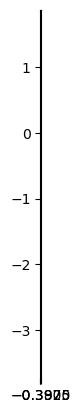

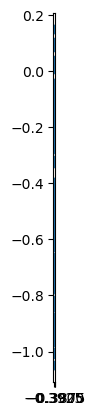

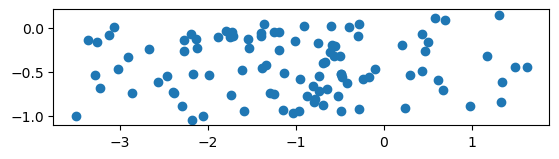

In [87]:
encoder.eval()
decoder.eval()

z = encoder(data)

plt.scatter(z[:,0].detach().numpy(), z[:,1].detach().numpy())
plt.gca().set_aspect('equal')
plt.show()

plt.scatter(z[:,0].detach().numpy(), z[:,2].detach().numpy())
plt.gca().set_aspect('equal')
plt.show()

plt.scatter(z[:,1].detach().numpy(), z[:,2].detach().numpy())
plt.gca().set_aspect('equal')
plt.show()

In [88]:
z.max(0)[0] - z.min(0)[0]

tensor([0.0060, 5.1248, 1.1987], grad_fn=<SubBackward0>)

In [89]:
z.T.cov()

tensor([[1.2434e-06, 1.1873e-05, 2.4854e-05],
        [1.1873e-05, 1.4860e+00, 2.6470e-03],
        [2.4854e-05, 2.6470e-03, 1.0443e-01]], grad_fn=<SqueezeBackward0>)

C:\Users\geniu\AppData\Local\Temp\ipykernel_170496\2915175676.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


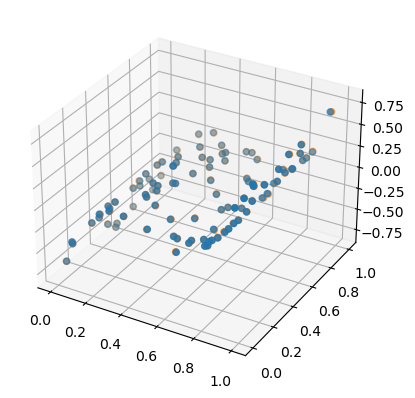

In [90]:
rec = decoder(z).detach().numpy()

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(XY[:,0].numpy(), XY[:,1].numpy(), Z.numpy())
ax.scatter(rec[:, 0], rec[:, 1], rec[:, 2])
fig.show()

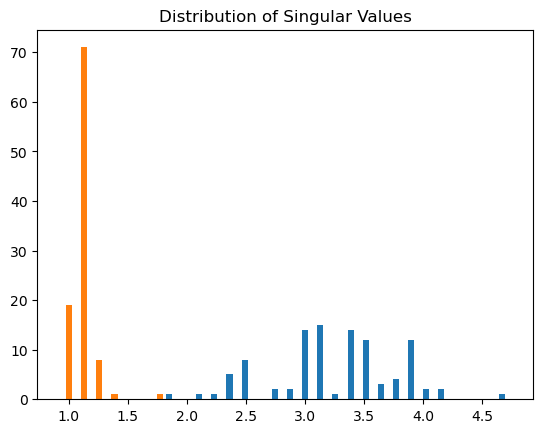

In [93]:
def f(x):
    return encoder(x).sum(0)

jcb = torch.autograd.functional.jacobian(f, data).transpose(1,0)
eig_list = torch.stack([svd(j[[1, 2]])[1] for j in jcb])
plt.hist(eig_list.numpy(), bins=30)
plt.title('Distribution of Singular Values')
plt.show()

C:\Users\geniu\AppData\Local\Temp\ipykernel_170496\3263359267.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


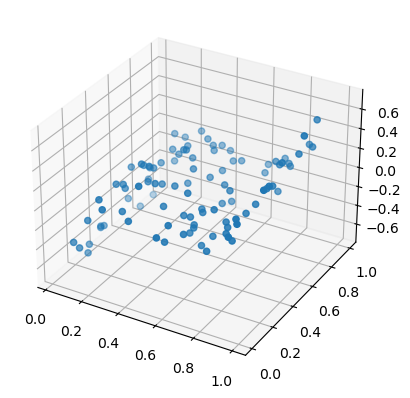

In [75]:
encoder = MLP(3, 3, [128]*4)
decoder = SNMLP(3, 3, [128]*4)
encoder.train()
decoder.train()

XY = torch.rand(100, 2)
X = XY[:, 0] - 0.5
Z = 10 * (X-0.3) * X * (X+0.3) + torch.randn(len(X))/10
data = torch.stack([XY[:,0], XY[:,1], Z], dim=-1)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(XY[:,0].numpy(), XY[:,1].numpy(), Z.numpy())
fig.show()

In [77]:
opt = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-4)

for i in range(10000):
    opt.zero_grad()
    z = encoder(data)
    rec_loss = F.mse_loss(decoder(z), data) 
    lasso_loss = torch.exp(torch.log(z.std(0)+1).mean())  # torch.norm(z.std(0), p=1)
    # lasso_loss = F.mse_loss(z.T.cov().tril(diagonal=-1), torch.zeros_like(z.T.cov()))
    loss = rec_loss + 0.02 * lasso_loss
    loss.backward()
    opt.step()

    if i % 100 == 0:
        print('Epoch {}: rec = {}, lasso = {}'.format(i, rec_loss, lasso_loss))

Epoch 0: rec = 0.06994380056858063, lasso = 1.0000534057617188
Epoch 100: rec = 0.0699426606297493, lasso = 1.0001318454742432
Epoch 200: rec = 0.06994370371103287, lasso = 1.0000605583190918
Epoch 300: rec = 0.0699433758854866, lasso = 1.0000649690628052
Epoch 400: rec = 0.0699291005730629, lasso = 1.0006780624389648
Epoch 500: rec = 0.0335916206240654, lasso = 1.1982134580612183
Epoch 600: rec = 0.03214793652296066, lasso = 1.1568636894226074
Epoch 700: rec = 0.031410396099090576, lasso = 1.1594346761703491
Epoch 800: rec = 0.030710561200976372, lasso = 1.1647119522094727
Epoch 900: rec = 0.029832474887371063, lasso = 1.178366780281067
Epoch 1000: rec = 0.028999365866184235, lasso = 1.1906640529632568
Epoch 1100: rec = 0.02767489105463028, lasso = 1.2083967924118042
Epoch 1200: rec = 0.005418349523097277, lasso = 1.3284519910812378
Epoch 1300: rec = 0.004297271370887756, lasso = 1.3465194702148438
Epoch 1400: rec = 0.0038770476821810007, lasso = 1.3589451313018799
Epoch 1500: rec = 0

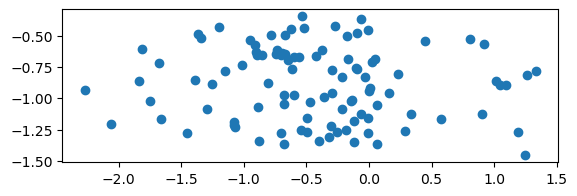

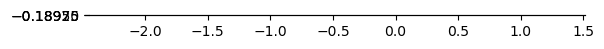

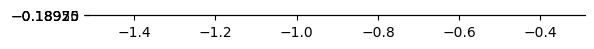

In [78]:
encoder.eval()
decoder.eval()

z = encoder(data)

plt.scatter(z[:,0].detach().numpy(), z[:,1].detach().numpy())
plt.gca().set_aspect('equal')
plt.show()

plt.scatter(z[:,0].detach().numpy(), z[:,2].detach().numpy())
plt.gca().set_aspect('equal')
plt.show()

plt.scatter(z[:,1].detach().numpy(), z[:,2].detach().numpy())
plt.gca().set_aspect('equal')
plt.show()

In [79]:
z.max(0)[0] - z.min(0)[0]

tensor([3.6013e+00, 1.1095e+00, 7.8353e-04], grad_fn=<SubBackward0>)

In [80]:
z.T.cov()

tensor([[ 5.5955e-01, -1.8570e-02,  4.2514e-06],
        [-1.8570e-02,  8.4877e-02, -9.5637e-06],
        [ 4.2514e-06, -9.5637e-06,  2.1057e-08]], grad_fn=<SqueezeBackward0>)

C:\Users\geniu\AppData\Local\Temp\ipykernel_170496\2915175676.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


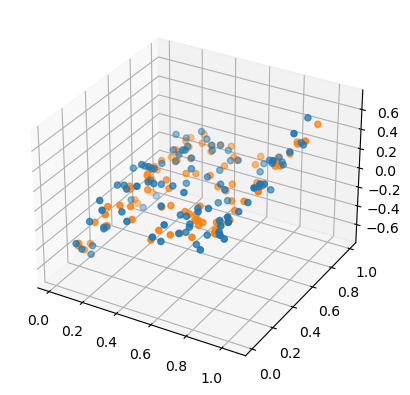

In [81]:
rec = decoder(z).detach().numpy()

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(XY[:,0].numpy(), XY[:,1].numpy(), Z.numpy())
ax.scatter(rec[:, 0], rec[:, 1], rec[:, 2])
fig.show()

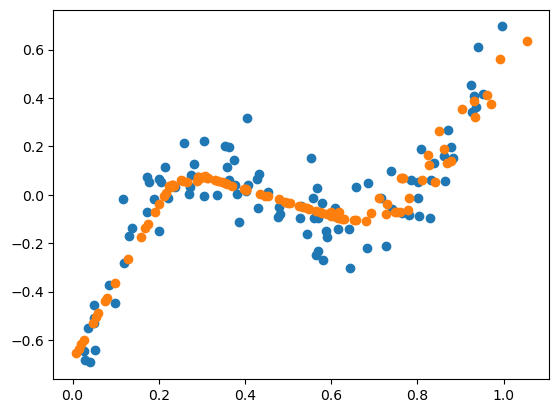

In [82]:
plt.scatter(XY[:,0].numpy(), Z.numpy())
plt.scatter(rec[:, 0], rec[:, 2])
plt.show()

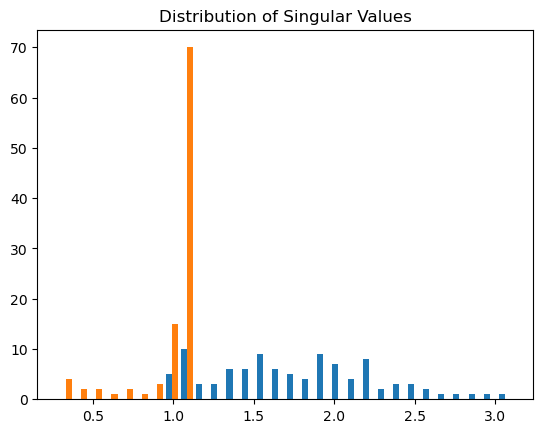

In [84]:
def f(x):
    return encoder(x).sum(0)

jcb = torch.autograd.functional.jacobian(f, data).transpose(1,0)
eig_list = torch.stack([svd(j[[0, 1]])[1] for j in jcb])
plt.hist(eig_list.numpy(), bins=30)
plt.title('Distribution of Singular Values')
plt.show()